In [1]:
import zipfile
import xml.etree.ElementTree as ET
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

In [4]:
def visualizar_imagenes_bbox(directorio_base, classes, num_imagenes=16):
    """
    Muestra imágenes con bounding boxes desde directorios extraídos.

    Args:
        directorio_base (str): Directorio que contiene las carpetas Images y Annotations
        classes (list): Lista de clases para asignar colores
        num_imagenes (int): Número de imágenes aleatorias a mostrar
    """
    # Definir colores para cada clase
    colors = ['#FF0000', '#00FF00', '#0000FF', '#FFA500', '#800080']
    class_colors = dict(zip(classes, colors))

    # Rutas a los directorios
    images_dir = os.path.join(directorio_base, "images")
    annot_dir = os.path.join(directorio_base, "Annotations")

    # Verificar que los directorios existan
    if not os.path.exists(images_dir) or not os.path.exists(annot_dir):
        raise ValueError(f"No se encontraron los directorios Images o Annotations en {directorio_base}")

    # Obtener lista de archivos
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        raise ValueError(f"No se encontraron imágenes en {images_dir}")

    # Seleccionar imágenes aleatorias
    selected_images = random.sample(image_files, min(num_imagenes, len(image_files)))

    # Configurar el mosaico
    rows = int(np.ceil(np.sqrt(num_imagenes)))
    cols = rows
    fig = plt.figure(figsize=(20, 20))

    # Crear grid para las imágenes
    gs = plt.GridSpec(rows+1, cols, height_ratios=[4]*rows + [1])

    # Contador para cada clase
    class_counts = {clase: 0 for clase in classes}

    # Para cada imagen seleccionada
    for idx, img_file in enumerate(selected_images):
        ax = plt.subplot(gs[idx//cols, idx%cols])

        # Cargar imagen
        img_path = os.path.join(images_dir, img_file)
        img = Image.open(img_path)

        # Encontrar archivo XML correspondiente
        xml_file = os.path.splitext(img_file)[0] + '.xml'
        xml_path = os.path.join(annot_dir, xml_file)

        # Mostrar imagen
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(img_file, fontsize=8)

        # Si existe el archivo XML, procesar los bounding boxes
        if os.path.exists(xml_path):
            tree = ET.parse(xml_path)
            root = tree.getroot()

            # Para cada objeto en la anotación
            for obj in root.findall('object'):
                name = obj.find('name').text
                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)

                # Actualizar contador de clases
                if name in class_counts:
                    class_counts[name] += 1

                # Obtener color para la clase
                color = class_colors.get(name, '#808080')

                # Dibujar rectángulo
                width = xmax - xmin
                height = ymax - ymin
                rect = patches.Rectangle(
                    (xmin, ymin), width, height,
                    linewidth=2, edgecolor=color, facecolor='none'
                )
                ax.add_patch(rect)

                # Añadir etiqueta
                ax.text(
                    xmin, ymin-10, name,
                    color=color, fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.7)
                )

    # Ocultar ejes vacíos
    for idx in range(len(selected_images), rows*cols):
        ax = plt.subplot(gs[idx//cols, idx%cols])
        ax.axis('off')

    # Añadir leyenda en la parte inferior con contadores
    legend_ax = plt.subplot(gs[-1, :])
    legend_ax.axis('off')
    legend_elements = [patches.Patch(facecolor=class_colors[class_name],
                                   label=f'{class_name} ({class_counts[class_name]})')
                      for class_name in classes]
    legend_ax.legend(handles=legend_elements, loc='center', ncol=len(classes),
                    bbox_to_anchor=(0.5, 0.5), fontsize=12)

    plt.tight_layout()
    plt.show()

    # Imprimir resumen de conteos
    print("\nResumen de instancias por clase:")
    for clase, count in class_counts.items():
        print(f"{clase}: {count} instancias")

In [5]:
classes = ["Aloe Vera", "Cedron", "Floripondio", "Higuera", "Nispero"]


directorio_destino = "D:\IA2 prisci\dataset5000"  # Directorio donde se extraerán los archivos



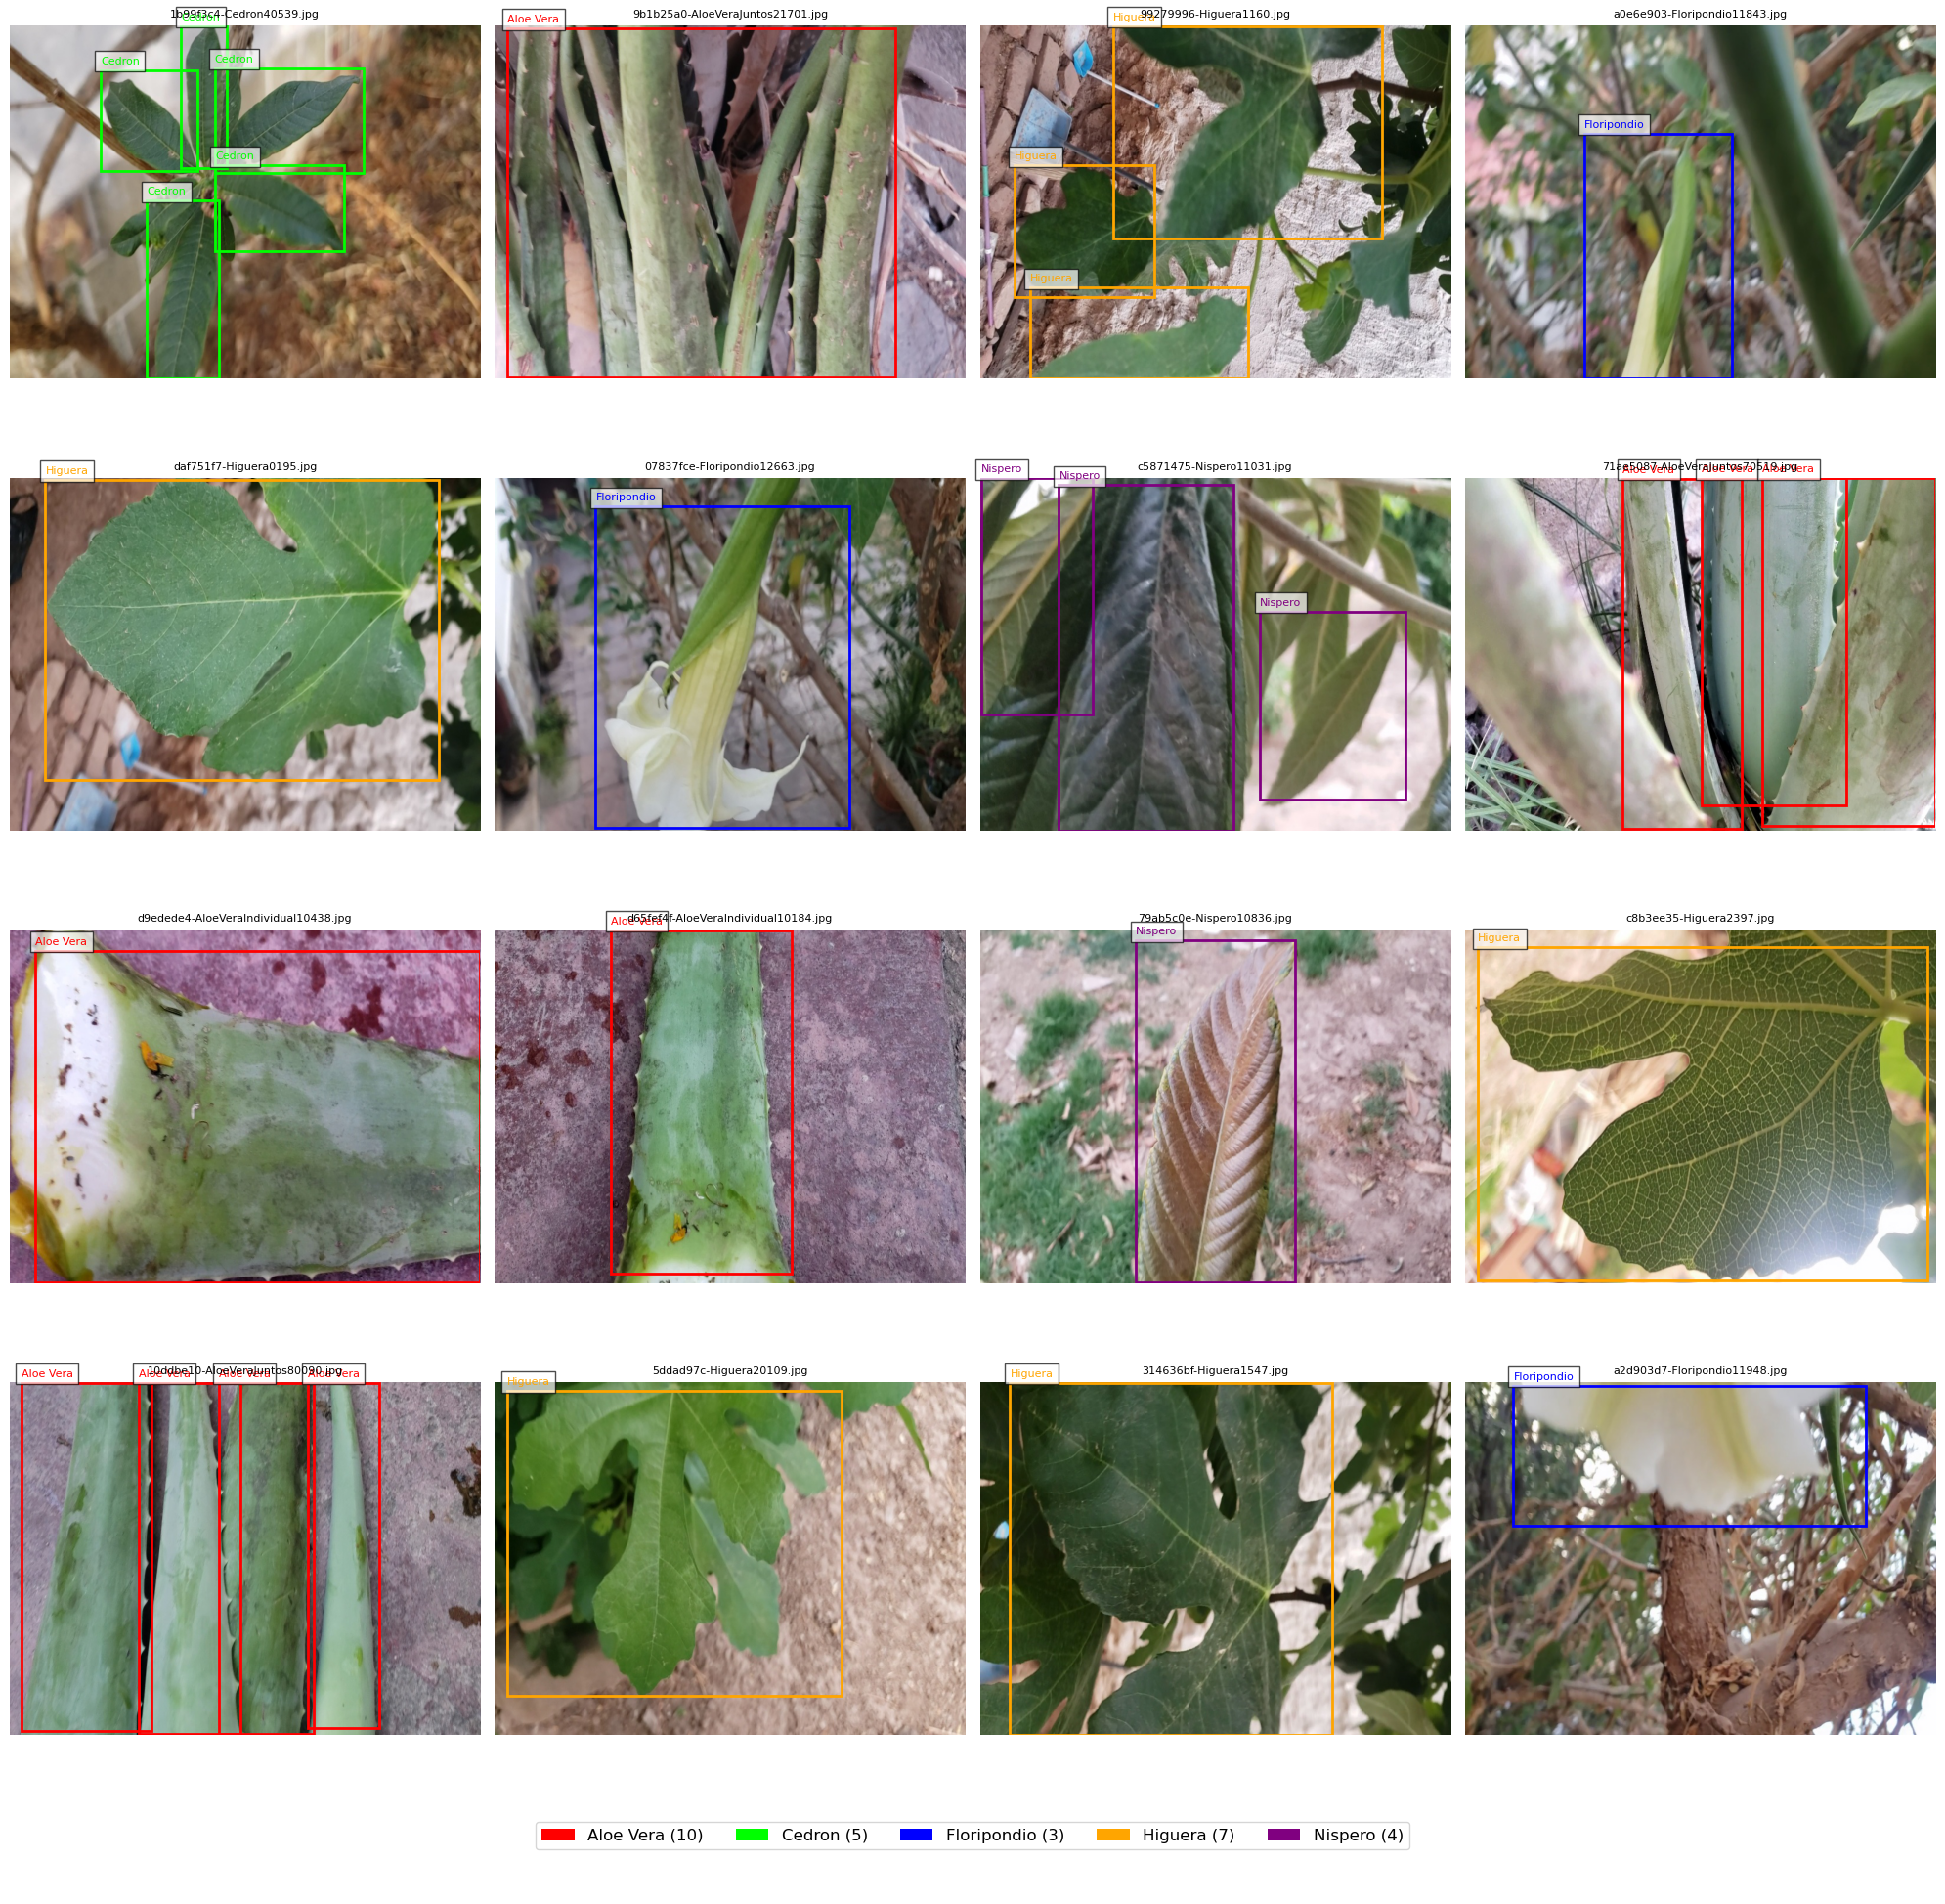


Resumen de instancias por clase:
Aloe Vera: 10 instancias
Cedron: 5 instancias
Floripondio: 3 instancias
Higuera: 7 instancias
Nispero: 4 instancias


In [6]:

# Visualizar las imágenes
visualizar_imagenes_bbox(directorio_destino, classes)

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import xml.etree.ElementTree as ET
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F


In [8]:
class PlantDataset(Dataset):
    """
    Dataset personalizado para el conjunto de datos de plantas con validación de boxes.
    """
    def __init__(self, img_dir, annot_dir, classes, transform=None):
        self.img_dir = img_dir
        self.annot_dir = annot_dir
        self.transform = transform
        self.classes = classes
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        # Obtener lista de archivos válidos
        self.images = []
        self.invalid_files = []

        for f in os.listdir(img_dir):
            if f.endswith(('.jpg', '.jpeg', '.png')):
                xml_file = os.path.join(annot_dir, os.path.splitext(f)[0] + '.xml')
                if self.validate_annotation(xml_file, os.path.join(img_dir, f)):
                    self.images.append(f)
                else:
                    self.invalid_files.append(f)

        print(f"Total imágenes válidas: {len(self.images)}")
        if self.invalid_files:
            print(f"Imágenes omitidas por boxes inválidos: {len(self.invalid_files)}")
            print("Primeros 5 archivos inválidos:", self.invalid_files[:5])

    def validate_annotation(self, xml_path, img_path):
        """
        Valida que los bounding boxes sean válidos para una imagen.
        """
        if not os.path.exists(xml_path):
            return False

        try:
            # Obtener dimensiones de la imagen
            with Image.open(img_path) as img:
                img_width, img_height = img.size

            tree = ET.parse(xml_path)
            root = tree.getroot()

            for obj in root.findall('object'):
                bbox = obj.find('bndbox')

                # Extraer coordenadas
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)

                # Validar coordenadas
                if not (0 <= xmin < xmax <= img_width and
                       0 <= ymin < ymax <= img_height and
                       xmax - xmin >= 1 and ymax - ymin >= 1):
                    return False

            return True
        except Exception as e:
            print(f"Error validando {xml_path}: {str(e)}")
            return False

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Cargar imagen
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Obtener dimensiones originales
        orig_width, orig_height = image.size

        # Cargar anotaciones
        xml_path = os.path.join(self.annot_dir, os.path.splitext(img_name)[0] + '.xml')
        boxes = []
        labels = []
        area = []
        iscrowd = []

        tree = ET.parse(xml_path)
        root = tree.getroot()

        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')

            # Extraer y validar coordenadas
            xmin = max(0, float(bbox.find('xmin').text))
            ymin = max(0, float(bbox.find('ymin').text))
            xmax = min(float(bbox.find('xmax').text), orig_width)
            ymax = min(float(bbox.find('ymax').text), orig_height)

            # Asegurar que el box tiene dimensiones positivas
            if xmax - xmin >= 1 and ymax - ymin >= 1:
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.class_to_idx[name])
                area.append((xmax - xmin) * (ymax - ymin))
                iscrowd.append(0)

        # Verificar que hay al menos un box válido
        if not boxes:
            # Crear un box ficticio fuera de la imagen si no hay boxes válidos
            boxes = [[0, 0, 1, 1]]
            labels = [0]  # clase background
            area = [1]
            iscrowd = [0]

        # Convertir a tensores
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        # Crear target dict
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # Aplicar transformaciones
        if self.transform:
            image, target = self.transform(image, target)

        return image, target

In [9]:
class Compose:
    """Compone varias transformaciones manteniendo los bboxes."""
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class Resize:
    """Redimensiona la imagen y los bboxes."""
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        # Obtener dimensiones originales
        orig_width, orig_height = image.size

        # Redimensionar imagen
        image = F.resize(image, self.size)

        # Ajustar bboxes
        if target is not None and "boxes" in target and len(target["boxes"]):
            boxes = target["boxes"]
            scaled_boxes = boxes.clone()
            scaled_boxes[:, [0, 2]] *= (self.size[1] / orig_width)
            scaled_boxes[:, [1, 3]] *= (self.size[0] / orig_height)
            target["boxes"] = scaled_boxes

            # Actualizar áreas
            target["area"] = (scaled_boxes[:, 2] - scaled_boxes[:, 0]) * \
                            (scaled_boxes[:, 3] - scaled_boxes[:, 1])

        return image, target

class ToTensor:
    """Convierte la imagen a tensor y normaliza."""
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

def get_transform():
    """
    Retorna las transformaciones necesarias para RetinaNet.
    Reduce el tamaño en un 80% (de 800x600 a 160x120).
    """
    transforms = [
        Resize((160, 120)),  # 80% menos de 600x800
        ToTensor()
    ]
    return Compose(transforms)

def collate_fn(batch):
    """Función personalizada para agrupar los datos en batches."""
    return tuple(zip(*batch))


In [10]:
def crear_dataloader(img_dir, annot_dir, classes, batch_size=8, num_workers=0):
    """
    Crea y retorna un DataLoader con el número correcto de workers.
    """
    # Definir transformaciones
    transform = Compose([
        Resize((160, 120)),  # 80% menos de 600x800
        ToTensor()
    ])

    # Crear dataset
    dataset = PlantDataset(
        img_dir=img_dir,
        annot_dir=annot_dir,
        classes=classes,
        transform=transform
    )

    # Crear dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=num_workers
    )

    return dataloader, dataset

In [11]:
def visualizar_batch(images, targets, dataset, class_colors):
    """
    Visualiza un batch de imágenes con sus bounding boxes.
    """
    batch_size = len(images)
    rows = int(np.ceil(np.sqrt(batch_size)))
    cols = rows

    fig = plt.figure(figsize=(20, 20))
    gs = plt.GridSpec(rows+1, cols, height_ratios=[4]*rows + [1])

    for idx, (image, target) in enumerate(zip(images, targets)):
        ax = plt.subplot(gs[idx//cols, idx%cols])

        # Convertir tensor a imagen
        img = image.permute(1, 2, 0).numpy()
        img = (img * 255).astype(np.uint8)

        # Mostrar imagen
        ax.imshow(img)
        ax.axis('off')

        # Dibujar bounding boxes
        boxes = target['boxes']
        labels = target['labels']

        for box, label in zip(boxes, labels):
            # Obtener coordenadas
            xmin, ymin, xmax, ymax = box.numpy()

            # Obtener clase y color
            class_name = dataset.classes[label]
            color = class_colors.get(class_name, '#808080')

            # Dibujar rectángulo
            rect = patches.Rectangle(
                (xmin, ymin), xmax-xmin, ymax-ymin,
                linewidth=2, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rect)

            # Añadir etiqueta
            ax.text(
                xmin, ymin-5, class_name,
                color=color, fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7)
            )

    # Añadir leyenda
    legend_ax = plt.subplot(gs[-1, :])
    legend_ax.axis('off')
    legend_elements = [patches.Patch(facecolor=color, label=class_name)
                      for class_name, color in class_colors.items()
                      if class_name != "background"]
    legend_ax.legend(handles=legend_elements, loc='center', ncol=len(dataset.classes)-1,
                    bbox_to_anchor=(0.5, 0.5), fontsize=12)

    plt.tight_layout()
    plt.show()

In [12]:
# Definir clases y colores (sin incluir background)
classes = ["Aloe Vera", "Cedron", "Floripondio", "Higuera", "Nispero"]
class_colors = {
    "Aloe Vera": '#FF0000',
    "Cedron": '#00FF00',
    "Floripondio": '#0000FF',
    "Higuera": '#FFA500',
    "Nispero": '#800080'
}

# Crear DataLoader
dataloader, dataset = crear_dataloader(
    img_dir='D:\IA2 prisci\dataset5000/images',
    annot_dir='D:\IA2 prisci\dataset5000/Annotations',
    classes=classes,
    batch_size=4
)

Total imágenes válidas: 5011
Imágenes omitidas por boxes inválidos: 2
Primeros 5 archivos inválidos: ['c750f22d-Nispero10677.jpg', 'cae3eca1-Nispero10390.jpg']


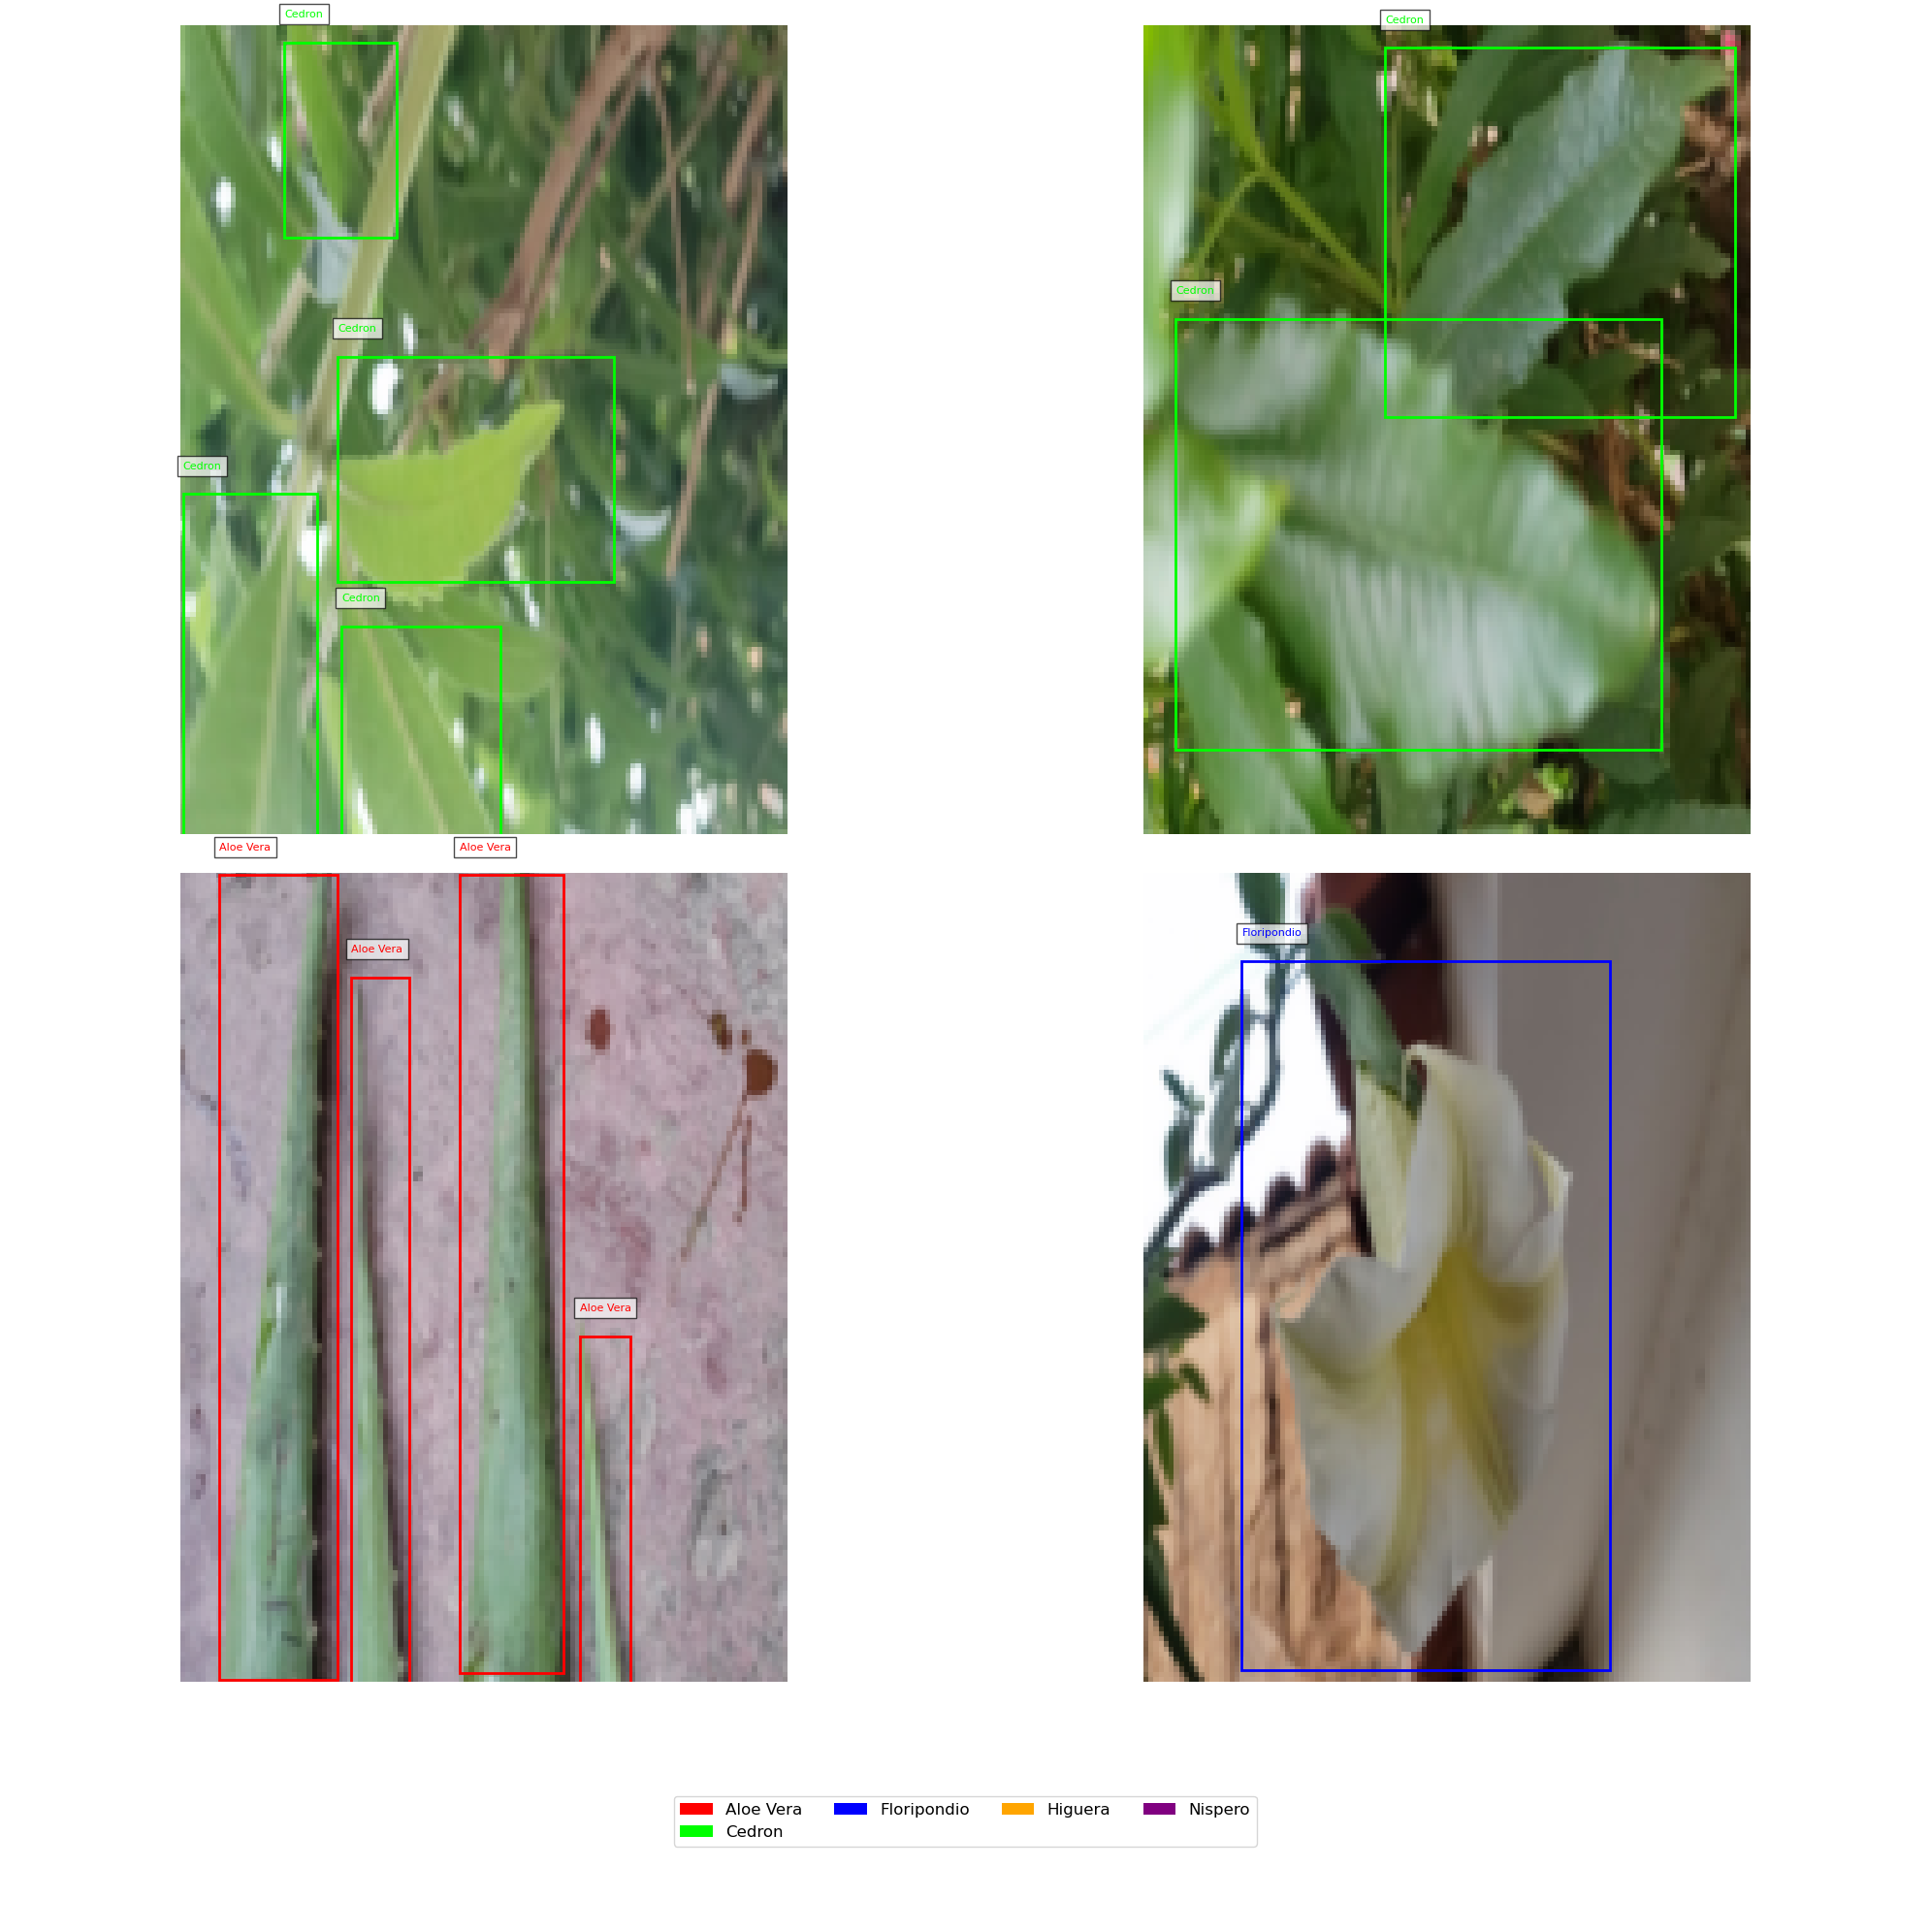

In [18]:

# Obtener y visualizar un batch
images, targets = next(iter(dataloader))
visualizar_batch(images, targets, dataset, class_colors)


In [19]:
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.retinanet import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
import time
import datetime
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import os

In [20]:
def create_model(num_classes, pretrained=True, freeze_backbone=True, dropout_rate=0.3):
    """
    Crea y configura el modelo RetinaNet con dropout.
    """
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    weights = RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT if pretrained else None
    model = retinanet_resnet50_fpn_v2(weights=weights)

    # Modificar la cabeza de clasificación y añadir dropout
    num_anchors = model.head.classification_head.num_anchors
    model.head.classification_head.num_classes = num_classes
    
    # Añadir dropout antes de la capa de clasificación final
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.head.classification_head.dropout = torch.nn.Dropout(p=dropout_rate)
    model.head.classification_head.cls_logits = torch.nn.Sequential(
        torch.nn.Dropout(p=dropout_rate),
        torch.nn.Conv2d(256, num_anchors * num_classes, kernel_size=3, stride=1, padding=1)
    ).to(device)

    if freeze_backbone:
        for param in model.backbone.parameters():
            param.requires_grad = False

    return model 

In [21]:
def plot_training_metrics(train_losses, val_losses, classification_losses, regression_losses, current_epoch):
    """
    Visualiza las métricas de entrenamiento.
    """
    plt.figure(figsize=(15, 10))
    
    # Plot de pérdidas totales
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot de pérdida de clasificación
    plt.subplot(2, 2, 2)
    plt.plot(classification_losses)
    plt.title('Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot de pérdida de regresión
    plt.subplot(2, 2, 3)
    plt.plot(regression_losses)
    plt.title('Regression Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'training_metrics_epoch_{current_epoch}.png')
    plt.close()    

In [22]:
   

def train_one_epoch(model, optimizer, data_loader, device, epoch, writer, print_freq=10):
    """
    Entrena el modelo por una época.
    """
    model.train()
    
    total_loss = 0
    classification_loss = 0
    regression_loss = 0
    
    len_dataloader = len(data_loader)
    
    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        
        # Calcular pérdida total
        losses = sum(loss for loss in loss_dict.values())
        
        # Actualizar métricas
        total_loss += losses.item()
        if 'classification' in loss_dict:
            classification_loss += loss_dict['classification'].item()
        if 'bbox_regression' in loss_dict:
            regression_loss += loss_dict['bbox_regression'].item()
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if i % print_freq == 0:
            print(f'Epoch: [{epoch}][{i}/{len_dataloader}]'
                  f' Loss: {losses.item():.4f}'
                  f' Class: {loss_dict["classification"].item():.4f}'
                  f' Box: {loss_dict["bbox_regression"].item():.4f}')
    
    # Calcular promedios
    avg_total_loss = total_loss / len_dataloader
    avg_classification_loss = classification_loss / len_dataloader
    avg_regression_loss = regression_loss / len_dataloader
    
    # Registrar en TensorBoard
    writer.add_scalar('Loss/train/total', avg_total_loss, epoch)
    writer.add_scalar('Loss/train/classification', avg_classification_loss, epoch)
    writer.add_scalar('Loss/train/regression', avg_regression_loss, epoch)
    
    return avg_total_loss

In [23]:

def validate(model, data_loader, device):
    """
    Valida el modelo en el conjunto de validación.
    """
    model.train()  # Necesario para calcular pérdidas
    total_loss = 0
    num_batches = len(data_loader)
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            try:
                # Calcular pérdidas
                loss_dict = model(images, targets)
                
                # Sumar pérdidas si es un diccionario
                if isinstance(loss_dict, dict):
                    batch_loss = sum(loss for loss in loss_dict.values())
                # Si es una lista, sumar directamente los elementos
                elif isinstance(loss_dict, list):
                    batch_loss = sum(loss_dict)
                else:
                    batch_loss = loss_dict
                
                total_loss += batch_loss.item()
            except Exception as e:
                print(f"Error en batch de validación: {str(e)}")
                continue
    
    return total_loss / num_batches

def train_model(train_loader, val_loader, num_classes, num_epochs=10, learning_rate=0.0001, 
                patience=5, dropout_rate=0.3, plot_interval=30):
    """
    Entrena el modelo RetinaNet con early stopping, dropout y visualización periódica.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Usando dispositivo: {device}')

    if torch.cuda.is_available():
        print(f'Memoria CUDA total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')
        print(f'Memoria CUDA disponible: {torch.cuda.memory_allocated() / 1e9:.2f} GB')

    # Crear modelo con dropout
    model = create_model(num_classes, pretrained=True, freeze_backbone=True, dropout_rate=dropout_rate)
    model = model.to(device)

    # Optimizador y scheduler
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3, verbose=True
    )

    # Configurar TensorBoard
    writer = SummaryWriter('runs/plant_detection')
    os.makedirs('checkpoints', exist_ok=True)

    # Variables para early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Listas para almacenar métricas
    train_losses = []
    val_losses = []
    classification_losses = []
    regression_losses = []

    print("Iniciando entrenamiento...")
    for epoch in range(num_epochs):
        print(f'\nÉpoca {epoch+1}/{num_epochs}')

        try:
            # Modo entrenamiento
            model.train()
            epoch_loss = 0
            epoch_class_loss = 0
            epoch_reg_loss = 0
            
            for i, (images, targets) in enumerate(train_loader):
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # Forward pass
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                # Actualizar métricas
                epoch_loss += losses.item()
                epoch_class_loss += loss_dict['classification'].item()
                epoch_reg_loss += loss_dict['bbox_regression'].item()

                # Backward pass
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

                if i % 10 == 0:
                    print(f'Batch [{i}/{len(train_loader)}] Loss: {losses.item():.4f}')

            # Calcular promedios
            avg_train_loss = epoch_loss / len(train_loader)
            avg_class_loss = epoch_class_loss / len(train_loader)
            avg_reg_loss = epoch_reg_loss / len(train_loader)

            # Validación
            val_loss = validate(model, val_loader, device)
            
            # Actualizar listas de métricas
            train_losses.append(avg_train_loss)
            val_losses.append(val_loss)
            classification_losses.append(avg_class_loss)
            regression_losses.append(avg_reg_loss)

            # Registrar en TensorBoard
            writer.add_scalar('Loss/train', avg_train_loss, epoch)
            writer.add_scalar('Loss/validation', val_loss, epoch)
            writer.add_scalar('Loss/classification', avg_class_loss, epoch)
            writer.add_scalar('Loss/regression', avg_reg_loss, epoch)

            # Visualizar métricas cada plot_interval épocas
            if (epoch + 1) % plot_interval == 0:
                plot_training_metrics(train_losses, val_losses, 
                                   classification_losses, regression_losses, 
                                   epoch + 1)

            # Early Stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Guardar mejor modelo
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                }, 'D:/IA2 prisci/checkpoints/best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'\nEarly stopping triggered after {epoch + 1} épocas')
                    break

            # Actualizar learning rate
            lr_scheduler.step(val_loss)

            # Guardar checkpoint cada 5 épocas
            if (epoch + 1) % 5 == 0:
                current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'classification_losses': classification_losses,
                    'regression_losses': regression_losses
                }, f'D:/IA2 prisci/checkpoints/model_epoch_{epoch+1}_{current_time}.pth')

        except Exception as e:
            print(f"Error en época {epoch+1}: {str(e)}")
            continue

    writer.close()
    
    # Plotear métricas finales
    plot_training_metrics(train_losses, val_losses, 
                         classification_losses, regression_losses, 
                         epoch + 1)

    return model

In [25]:
def predict_batch(model, images, device, confidence_threshold=0.5):
    """
    Realiza predicciones en un batch de imágenes.

    Args:
        model: Modelo entrenado
        images: Lista de imágenes tensor
        device: Dispositivo (cuda/cpu)
        confidence_threshold: Umbral de confianza para las detecciones
    """
    model.eval()
    images = [img.to(device) for img in images]

    with torch.no_grad():
        predictions = model(images)

    # Filtrar predicciones por confianza
    filtered_predictions = []
    for pred in predictions:
        scores = pred['scores']
        high_conf_idx = scores >= confidence_threshold

        filtered_pred = {
            'boxes': pred['boxes'][high_conf_idx],
            'labels': pred['labels'][high_conf_idx],
            'scores': scores[high_conf_idx]
        }
        filtered_predictions.append(filtered_pred)

    return filtered_predictions

In [26]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Crear índices para la división
dataset_size = len(dataset)
indices = list(range(dataset_size))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)
# Definir clases
classes = ["Aloe Vera", "Cedron", "Floripondio", "Higuera", "Nispero"]

# Crear dataloaders con 2 workers (o el número que prefieras)
train_dataset_size = int(0.8 * len(dataset))
val_dataset_size = len(dataset) - train_dataset_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_dataset_size, val_dataset_size]
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0  # Sin workers paralelos
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0  # Sin workers paralelos
)

# Entrenar el modelo
num_classes = len(classes)
print(num_classes)

5


In [ ]:
model = train_model(
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=num_classes,
    num_epochs=200,
    learning_rate=0.0001,
    patience=5,  # Early stopping patience
    dropout_rate=0.3,  # Tasa de dropout
    plot_interval=5  # Intervalo para generar gráficas
)

Usando dispositivo: cuda
Memoria CUDA total: 4.29 GB
Memoria CUDA disponible: 0.00 GB


C:\Users\USER\miniconda3\envs\IA2\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Iniciando entrenamiento...

Época 1/200
Batch [0/1002] Loss: 2644.8677
Batch [10/1002] Loss: 867.0997
Batch [20/1002] Loss: 164.6568
Batch [30/1002] Loss: 46.0765
Batch [40/1002] Loss: 87.5855
Batch [50/1002] Loss: 9.8907
Batch [60/1002] Loss: 7.2623
Batch [70/1002] Loss: 10.3914
Batch [80/1002] Loss: 4.4419
Batch [90/1002] Loss: 2.3484
Batch [100/1002] Loss: 2.6595
Batch [110/1002] Loss: 2.1386
Batch [120/1002] Loss: 2.0959
Batch [130/1002] Loss: 2.5059
Batch [140/1002] Loss: 1.6766
Batch [150/1002] Loss: 1.4816
Batch [160/1002] Loss: 2.4406
Batch [170/1002] Loss: 1.5115
Batch [180/1002] Loss: 1.4162
Batch [190/1002] Loss: 1.5115
Batch [200/1002] Loss: 1.4535
Batch [210/1002] Loss: 1.5447
Batch [220/1002] Loss: 1.2476
Batch [230/1002] Loss: 1.3886
Batch [240/1002] Loss: 1.3013
Batch [250/1002] Loss: 1.3553
Batch [260/1002] Loss: 1.4588
Batch [270/1002] Loss: 1.1840
Batch [280/1002] Loss: 1.3062
Batch [290/1002] Loss: 1.4053
Batch [300/1002] Loss: 1.2515
Batch [310/1002] Loss: 1.2366
B

In [34]:
def get_num_classes_from_checkpoint(checkpoint_path, device='cpu'):
    """
    Obtiene el número de clases del modelo guardado en el checkpoint.
    
    Args:
        checkpoint_path: Ruta al checkpoint
        device: Dispositivo donde cargar el checkpoint
    
    Returns:
        int: Número de clases en el modelo guardado
    """
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        state_dict = checkpoint['model_state_dict']
        
        # Obtener forma del tensor de la capa de clasificación
        cls_weights_shape = state_dict['head.classification_head.cls_logits.weight'].shape
        num_anchors = 9  # Valor típico para RetinaNet
        num_classes = cls_weights_shape[0] // num_anchors
        
        return num_classes
    except Exception as e:
        print(f"Error al obtener número de clases del checkpoint: {str(e)}")
        return None

def cargar_checkpoint(checkpoint_path, model=None, optimizer=None, device='cpu', num_classes=None):
    """
    Carga un checkpoint guardado asegurando compatibilidad de clases.
    
    Args:
        checkpoint_path: Ruta al archivo checkpoint
        model: Modelo en el que cargar los pesos (si es None, se creará uno nuevo)
        optimizer: Optimizador en el que cargar el estado (opcional)
        device: Dispositivo donde cargar el modelo
        num_classes: Número de clases para el modelo (si es None, se detectará del checkpoint)
    """
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        # Obtener número de clases del checkpoint si no se especificó
        if num_classes is None:
            num_classes = get_num_classes_from_checkpoint(checkpoint_path, device)
            if num_classes is None:
                raise ValueError("No se pudo determinar el número de clases del checkpoint")
        
        # Crear nuevo modelo si no se proporcionó uno
        if model is None:
            from torchvision.models.detection.retinanet import retinanet_resnet50_fpn_v2
            model = retinanet_resnet50_fpn_v2(num_classes=num_classes)
        
        # Verificar y ajustar la capa de clasificación si es necesario
        current_classes = model.head.classification_head.num_classes
        if current_classes != num_classes:
            print(f"Ajustando modelo de {current_classes} a {num_classes} clases...")
            num_anchors = model.head.classification_head.num_anchors
            model.head.classification_head.num_classes = num_classes
            model.head.classification_head.cls_logits = torch.nn.Conv2d(
                256, num_anchors * num_classes, kernel_size=3, stride=1, padding=1
            )
        
        # Cargar pesos que coincidan
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in checkpoint['model_state_dict'].items() 
                          if k in model_dict and v.shape == model_dict[k].shape}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
        
        # Cargar estado del optimizador si se proporcionó
        if optimizer is not None and 'optimizer_state_dict' in checkpoint:
            try:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            except Exception as e:
                print(f"Advertencia: No se pudo cargar el estado del optimizador: {str(e)}")
        
        epoch = checkpoint.get('epoch', -1)
        best_val_loss = checkpoint.get('val_loss', float('inf'))
        
        print(f"Checkpoint cargado exitosamente desde época {epoch+1}")
        print(f"Mejor pérdida de validación: {best_val_loss:.4f}")
        
        return model, optimizer, epoch, best_val_loss
    
    except Exception as e:
        print(f"Error cargando checkpoint: {str(e)}")
        return model, optimizer, -1, float('inf')

In [36]:
def continuar_entrenamiento(
    model, 
    optimizer, 
    train_loader, 
    val_loader, 
    checkpoint_path,
    num_epochs=10,
    device='cpu',
    learning_rate=0.0001,
    save_dir='checkpoints',
    tensorboard_dir='runs/plant_detection_continued'
):
    """
    Continúa el entrenamiento desde un checkpoint.
    """
    # Asegurar que existan los directorios
    os.makedirs(save_dir, exist_ok=True)
    
    # Detectar número de clases del checkpoint
    num_classes = get_num_classes_from_checkpoint(checkpoint_path, device)
    
    # Cargar checkpoint
    model, optimizer, last_epoch, best_val_loss = cargar_checkpoint(
        checkpoint_path, 
        model, 
        optimizer, 
        device,
        num_classes=num_classes
    )
    
    # Si no se pudo cargar el optimizador, crear uno nuevo
    if optimizer is None:
        optimizer = torch.optim.Adam(
            [p for p in model.parameters() if p.requires_grad],
            lr=learning_rate
        )

def mostrar_info_checkpoint(checkpoint_path, device='cpu'):
    """
    Muestra información detallada sobre un checkpoint guardado.
    """
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        num_classes = get_num_classes_from_checkpoint(checkpoint_path, device)
        
        print("\nInformación del checkpoint:")
        print(f"Época: {checkpoint.get('epoch', 'No disponible')}")
        print(f"Pérdida de validación: {checkpoint.get('val_loss', 'No disponible'):.4f}")
        print(f"Número de clases: {num_classes}")
        
        # Mostrar estructura del modelo
        if 'model_state_dict' in checkpoint:
            print("\nEstructura del modelo:")
            for key, tensor in checkpoint['model_state_dict'].items():
                print(f"- {key}: {tensor.shape}")
        
        # Mostrar información del optimizador
        if 'optimizer_state_dict' in checkpoint:
            opt_state = checkpoint['optimizer_state_dict']
            print("\nInformación del optimizador:")
            if 'param_groups' in opt_state:
                for group in opt_state['param_groups']:
                    print(f"Learning rate: {group.get('lr', 'No disponible')}")
        
    except Exception as e:
        print(f"Error al cargar el checkpoint: {str(e)}")

In [78]:
# Primero, veamos la información del checkpoint
mostrar_info_checkpoint('D:/IA2 prisci/checkpoints/best_model.pth')

# Crear modelo base (opcional, la función puede crearlo automáticamente)
model = create_model(num_classes, pretrained=True, freeze_backbone=True)
optimizer = torch.optim.Adam(
    [p for p in model.parameters() if p.requires_grad],
    lr=0.0001
)

# Continuar entrenamiento
model = continuar_entrenamiento(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    checkpoint_path='checkpoints/best_model.pth',
    num_epochs=5,
    device=device,
    save_dir='checkpoints_continued'
)

C:\Users\USER\AppData\Local\Temp\ipykernel_6536\475161889.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)



Información del checkpoint:
Época: 16
Pérdida de validación: 0.6563

Estructura del modelo:
- backbone.body.conv1.weight
- backbone.body.bn1.weight
- backbone.body.bn1.bias
- backbone.body.bn1.running_mean
- backbone.body.bn1.running_var
- backbone.body.bn1.num_batches_tracked
- backbone.body.layer1.0.conv1.weight
- backbone.body.layer1.0.bn1.weight
- backbone.body.layer1.0.bn1.bias
- backbone.body.layer1.0.bn1.running_mean
- backbone.body.layer1.0.bn1.running_var
- backbone.body.layer1.0.bn1.num_batches_tracked
- backbone.body.layer1.0.conv2.weight
- backbone.body.layer1.0.bn2.weight
- backbone.body.layer1.0.bn2.bias
- backbone.body.layer1.0.bn2.running_mean
- backbone.body.layer1.0.bn2.running_var
- backbone.body.layer1.0.bn2.num_batches_tracked
- backbone.body.layer1.0.conv3.weight
- backbone.body.layer1.0.bn3.weight
- backbone.body.layer1.0.bn3.bias
- backbone.body.layer1.0.bn3.running_mean
- backbone.body.layer1.0.bn3.running_var
- backbone.body.layer1.0.bn3.num_batches_tracked
-

C:\Users\USER\AppData\Local\Temp\ipykernel_6536\1311751915.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Ajustando modelo de 7 a 6 clases...
Checkpoint cargado exitosamente desde época 17
Mejor pérdida de validación: 0.6563

Continuando entrenamiento...
Épocas previas completadas: 17
Épocas adicionales a entrenar: 5

Época 18/22

Error durante el entrenamiento: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

Entrenamiento adicional completado en 0:00:01
Mejor pérdida de validación: 0.6563


In [80]:
model = continuar_entrenamiento(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    checkpoint_path='checkpoints/best_model.pth',
    num_epochs=5,
    device=device,
    save_dir='checkpoints_continued'
)

C:\Users\USER\AppData\Local\Temp\ipykernel_6536\1311751915.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Checkpoint cargado exitosamente desde época 17
Mejor pérdida de validación: 0.6563

Continuando entrenamiento...
Épocas previas completadas: 17
Épocas adicionales a entrenar: 5

Época 18/22
Epoch: [17][0/107] Loss: 0.6630 Class: 0.4987 Box: 0.1644
Epoch: [17][10/107] Loss: 0.3857 Class: 0.3357 Box: 0.0500
Epoch: [17][20/107] Loss: 0.6045 Class: 0.4920 Box: 0.1125
Epoch: [17][30/107] Loss: 0.5902 Class: 0.4850 Box: 0.1052
Epoch: [17][40/107] Loss: 0.6693 Class: 0.5253 Box: 0.1439
Epoch: [17][50/107] Loss: 0.4726 Class: 0.3845 Box: 0.0881
Epoch: [17][60/107] Loss: 0.4984 Class: 0.4039 Box: 0.0945
Epoch: [17][70/107] Loss: 0.4219 Class: 0.3474 Box: 0.0745
Epoch: [17][80/107] Loss: 0.4627 Class: 0.3787 Box: 0.0840
Epoch: [17][90/107] Loss: 0.5659 Class: 0.4443 Box: 0.1216
Epoch: [17][100/107] Loss: 0.7469 Class: 0.6264 Box: 0.1205
Epoch 18 - Train Loss: 0.5948, Val Loss: 0.6482

Época 19/22
Epoch: [18][0/107] Loss: 0.5681 Class: 0.4508 Box: 0.1173
Epoch: [18][10/107] Loss: 0.6143 Class: 0.

In [50]:
 import cv2
def visualizar_predicciones(model, dataset, dataloader, device, classes, class_colors, num_images=16, confidence_threshold=0.5):
    """
    Visualiza las predicciones del modelo comparadas con los ground truth.

    Args:
        model: Modelo entrenado
        dataset: Dataset original
        dataloader: DataLoader de prueba
        device: Dispositivo (cuda/cpu)
        classes: Lista de clases
        class_colors: Diccionario de colores por clase
        num_images: Número de imágenes a visualizar
        confidence_threshold: Umbral de confianza para mostrar predicciones
    """
    model.eval()
    images, targets = next(iter(dataloader))
    predictions = predict_batch(model, images, device, confidence_threshold)

    # Configurar el grid de visualización
    num_images = min(num_images, len(images))
    rows = int(np.ceil(np.sqrt(num_images)))
    cols = rows
    fig = plt.figure(figsize=(20, 20))
    gs = plt.GridSpec(rows+1, cols, height_ratios=[4]*rows + [1])

    for idx in range(num_images):
        ax = plt.subplot(gs[idx//cols, idx%cols])

        # Convertir tensor a imagen
        img = images[idx].permute(1, 2, 0).numpy()
        img = (img * 255).astype(np.uint8)

        # Mostrar imagen
        ax.imshow(img)
        ax.set_title(f'Imagen {idx+1}', fontsize=10)
        ax.axis('off')

        # Obtener dimensiones de la imagen
        height, width = img.shape[:2]

        # Dibujar ground truth boxes (en verde sólido)
        gt_boxes = targets[idx]['boxes'].cpu()
        gt_labels = targets[idx]['labels'].cpu()
        for box, label_idx in zip(gt_boxes, gt_labels):
            xmin, ymin, xmax, ymax = box.numpy()
            class_name = dataset.classes[label_idx]

            # Rectángulo ground truth (línea punteada)
            rect = patches.Rectangle(
                (xmin, ymin), xmax-xmin, ymax-ymin,
                linewidth=2, linestyle='--',
                edgecolor='green', facecolor='none'
            )
            ax.add_patch(rect)

            # Etiqueta ground truth
            ax.text(
                xmin, ymin-5, f'GT: {class_name}',
                color='green', fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7)
            )

        # Dibujar predicted boxes
        pred = predictions[idx]
        pred_boxes = pred['boxes'].cpu()
        pred_labels = pred['labels'].cpu()
        pred_scores = pred['scores'].cpu()

        for box, label_idx, score in zip(pred_boxes, pred_labels, pred_scores):
            if score >= confidence_threshold:
                xmin, ymin, xmax, ymax = box.numpy()
                class_name = dataset.classes[label_idx]
                color = class_colors.get(class_name, '#808080')

                # Rectángulo predicción (línea sólida)
                rect = patches.Rectangle(
                    (xmin, ymin), xmax-xmin, ymax-ymin,
                    linewidth=2, linestyle='-',
                    edgecolor=color, facecolor='none'
                )
                ax.add_patch(rect)

                # Etiqueta predicción con score
                ax.text(
                    xmin, ymax+5,
                    f'Pred: {class_name} ({score:.2f})',
                    color=color, fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.7)
                )

    # Añadir leyenda
    legend_ax = plt.subplot(gs[-1, :])
    legend_ax.axis('off')

    # Elementos de leyenda para ground truth y predicciones
    legend_elements = [
        patches.Patch(facecolor='none', edgecolor='green', linestyle='--',
                     label='Ground Truth'),
        *[patches.Patch(facecolor=color, label=class_name)
          for class_name, color in class_colors.items()
          if class_name != "background"]
    ]

    legend_ax.legend(handles=legend_elements, loc='center',
                    ncol=len(classes), bbox_to_anchor=(0.5, 0.5),
                    fontsize=12)

    plt.tight_layout()
    plt.show()

def visualizar_prediccion_imagen(model, image_path, dataset, device, class_colors, confidence_threshold=0.2):
    """
    Visualiza las predicciones del modelo en una imagen.
    """
    import cv2
    import torch
    import numpy as np
    
    # Asegurarse de que el modelo esté en el dispositivo correcto
    model = model.to(device)
    
    # Cargar y redimensionar la imagen
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"No se pudo cargar la imagen desde {image_path}")
    image = cv2.resize(image, (160, 120))
    
    # Preparar la imagen para el modelo
    image_tensor = torch.from_numpy(image.transpose(2, 0, 1)).float().div(255.0).unsqueeze(0)
    image_tensor = image_tensor.to(device)
    
    # Realizar predicción
    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)
    
    # Mover las predicciones a CPU para procesamiento
    boxes = predictions[0]['boxes'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    
    # Filtrar predicciones por umbral de confianza
    mask = scores >= confidence_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    # Definir colores por defecto si no se proporcionan
    default_colors = {
        'class1': (0, 255, 0),    # Verde en BGR
        'class2': (255, 0, 0),    # Azul en BGR
        'class3': (0, 0, 255),    # Rojo en BGR
    }
    
    # Dibujar las predicciones
    image_with_boxes = image.copy()
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.astype(int)
        class_name = dataset.classes[label]
        
        # Asegurarse de que el color sea una tupla BGR válida
        color = class_colors.get(class_name, default_colors.get('class1'))
        if not isinstance(color, tuple) or len(color) != 3:
            color = (0, 255, 0)  # Verde por defecto si el color no es válido
        
        # Dibujar rectángulo
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), color, 2)
        
        # Añadir etiqueta con confianza
        label_text = f'{class_name}: {score:.2f}'
        cv2.putText(image_with_boxes, label_text, (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Mostrar imagen
    cv2.imshow('Predicciones', image_with_boxes)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return image_with_boxes


In [51]:
def visualizar_metricas_entrenamiento(log_dir):
    """
    Visualiza las métricas de entrenamiento desde TensorBoard.

    Args:
        log_dir: Directorio donde se guardaron los logs de TensorBoard
    """
    from tensorboard.backend.event_processing import event_accumulator

    # Cargar eventos
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()

    # Obtener las métricas
    train_loss = ea.scalars.Items('Loss/train/total')
    val_loss = ea.scalars.Items('Loss/val')
    class_loss = ea.scalars.Items('Loss/train/classification')
    box_loss = ea.scalars.Items('Loss/train/regression')

    # Crear subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Graficar pérdidas de entrenamiento y validación
    epochs = range(len(train_loss))
    ax1.plot(epochs, [x.value for x in train_loss], label='Train Loss')
    ax1.plot(epochs, [x.value for x in val_loss], label='Val Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Graficar pérdidas específicas
    ax2.plot(epochs, [x.value for x in class_loss], label='Classification Loss')
    ax2.plot(epochs, [x.value for x in box_loss], label='Box Regression Loss')
    ax2.set_title('Component Losses')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [52]:
model, optimizer, last_epoch, best_val_loss = cargar_checkpoint(
    'D:/IA2 prisci/checkpoints/best_model.pth',
    model,
    optimizer,
    device
)


C:\Users\USER\AppData\Local\Temp\ipykernel_17192\1311751915.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

Checkpoint cargado exitosamente desde época 17
Mejor pérdida de validación: 0.6563


C:\Users\USER\AppData\Local\Temp\ipykernel_17192\1311751915.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

In [ ]:
classes = ["background", "Aloe Vera", "Cedron", "Floripondio", "Higuera", "Nispero"]
class_colors = {
    "Aloe Vera": '#FF0000',
    "Cedron": '#00FF00',
    "Floripondio": '#0000FF',
    "Higuera": '#FFA500',
    "Nispero": '#800080'
}

# Visualizar predicciones en batch
visualizar_predicciones(
    model=model,
    dataset=dataset,
    dataloader=val_loader,
    device=device,
    classes=classes,
    class_colors=class_colors,
    num_images=4,
    confidence_threshold=0.3
)

